<a href="https://colab.research.google.com/github/tinetor/Covid/blob/master/MLOPS_FRAUD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dagshub mlflow

In [2]:
import mlflow

In [3]:
import dagshub
dagshub.init(repo_owner='tiago_netor', repo_name='antifraud_ml', mlflow=True)

Accessing as tiago_netor

Initialized MLflow to track repo "tiago_netor/antifraud_ml"

Repository tiago_netor/antifraud_ml initialized!

In [4]:
import dagshub.colab
#DAGSHUB_REPO = dagshub.colab.login()

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("whenamancodes/fraud-detection")

print("Path to dataset files:", path)


import pandas as pd
import os

# Assuming 'path' variable holds the correct directory path
try:
    # List files in the directory to verify
    print("Files in directory:", os.listdir(path))

    # Find the CSV file within the directory
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            csv_file_path = os.path.join(path, filename)
            break
    else:
        raise FileNotFoundError("No CSV file found in the specified directory.")

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)
    print("CSV file read successfully!")
    print(df.head())

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Path to dataset files: /root/.cache/kagglehub/datasets/whenamancodes/fraud-detection/versions/1
Files in directory: ['creditcard.csv']
CSV file read successfully!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Define X (features) and y (target)
X = df.drop(columns=["Class"])  # Remove target column
y = df["Class"]  # Define target

# Split dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
mlflow.xgboost.autolog()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import joblib
import matplotlib.pyplot as plt

2025/01/29 18:16:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:16:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/01/29 18:17:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxgf_dcu4/model, flavor: xgboost). Fall back to return ['xgboost==2.1.3']. Set logging level to DEBUG to see the full traceback. 
Registered model 'MyXGBoostModel' already exists. Creating a new version of this model...


🏃 View run gifted-cow-389 at: https://dagshub.com/tiago_netor/antifraud_ml.mlflow/#/experiments/0/runs/836e1e6bca714b008d2a31177b080bd2
🧪 View experiment at: https://dagshub.com/tiago_netor/antifraud_ml.mlflow/#/experiments/0


MlflowException: API request to https://dagshub.com/tiago_netor/antifraud_ml.mlflow/api/2.0/mlflow/model-versions/create failed with exception HTTPSConnectionPool(host='dagshub.com', port=443): Max retries exceeded with url: /tiago_netor/antifraud_ml.mlflow/api/2.0/mlflow/model-versions/create (Caused by ResponseError('too many 500 error responses'))

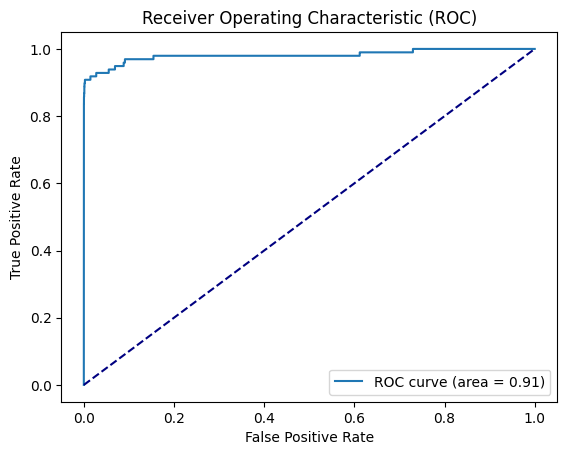

<Figure size 1000x800 with 0 Axes>

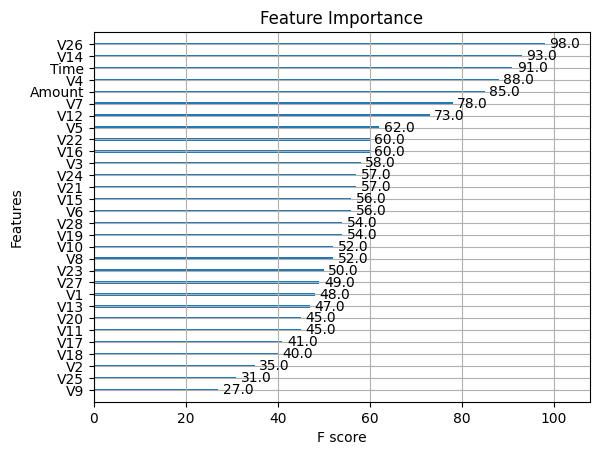

In [21]:
#mlflow.autolog()

with mlflow.start_run():
    # 1. Train the model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    # 2. Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probability for KS

    # 3. Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate KS Statistic
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    ks_statistic = max(tpr - fpr)  # KS is the max difference between TPR and FPR

    # Log metrics manually
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("ks_statistic", ks_statistic)

    # 4. Log the model artifact
    model_path = "xgboost_model.pkl"
    joblib.dump(model, model_path)
    mlflow.log_artifact(model_path)  # Log model file

    # 5. Log performance plots as artifacts
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {ks_statistic:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")  # Log ROC curve plot

    # 6. Log feature importance plot as artifact
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='weight')
    plt.title('Feature Importance')
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")  # Log feature importance plot

